<a href="https://colab.research.google.com/github/reneepc/Energia-e-Clima/blob/master/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Obs: Pretendia-se inicialmente fazer uma análise do consumo de energia diário de apartamentos baseado no dia do ano e nas condições climáticas. Os dados utilizados foram coletados do banco de dados UMass Smart* Dataset - 2017. Foi realizado um tratamento nos dados para obter o consumo diário e total em cada ano, baseando-se em intervalos de medições variáveis para cada arquivo e ano.

Dados brutos: http://traces.cs.umass.edu/index.php/Smart/Smart

Dados tratados: https://github.com/reneepc/Energia-e-Clima

Contudo, quando foram realizados os testes de predição com o Tensorflow, o comportamento do modelo se mostrou completamente caótico e claramente equivocado. Por falta de tempo para o tratamento de um novo banco de dados, optou-se por realizar a análise de um banco de dados já disponível no próprio tensorflow.


O objetivo desta análise é obter um modelo classificatório para o banco de imagens CIFAR-10, o qual permita realizar previsões com precisão.

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# CIFAR-10

O banco de imagens CIFAR-10 possui 10 categorias de imagens previamente estabelecidas, cada uma com 6000 exemplares de 32x32 pixels. A divisão entre conjunto de treino e teste é feita pelo próprio Tensorflow, sendo 50 000 imagens dedicadas para a criação do modelo e 10 000 para a sua avaliação.


In [155]:
imagens = tf.keras.datasets.cifar10
treino, teste = imagens.load_data()
print("Treino: {} imagens RGB,com {}x{} pixels cada".format(treino[0].shape[0],
                                                         treino[0].shape[1],
                                                         treino[0].shape[2]))
print("Teste: {} imagens RGB,com {}x{} pixels cada".format(teste[0].shape[0],
                                                         teste[0].shape[1],
                                                         teste[0].shape[2]))
legendas = ["Avião", "Carro", "Pássaro", "Gato", "Cervo", "Cachorro", "Sapo",
            "Cavalo", "Ovelha", "Caminhão"]

Treino: 50000 imagens RGB,com 32x32 pixels cada
Teste: 10000 imagens RGB,com 32x32 pixels cada


## Avaliação do Melhor Modelo
Para cada modelo avaliado, iremos fazer o gráfico da evolução da acurácia com o número de epochs, bem como da perda com o número de epochs.

Buscaremos aumentar a acurácia através da adição de camadas à uma rede neural inicial, tentando encontrar os parâmetros de maior impacto para esse incremento.

In [156]:
def plota_modelo(historico): 
    plt.subplot(1,2,1)
    plt.plot(historico.history['accuracy']) 
    plt.title('Acurácia vs Epoch')
    plt.ylabel('Acurácia') 
    plt.xlabel('Epoch')
    plt.legend(['Teste', 'Validação'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss']) 
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss') 
    plt.xlabel('Epoch')
    plt.legend(['Teste', 'Validação'], loc='upper left')
    plt.show()

### Parâmetros
O número padrão de epochs avaliadas será 10. O modelo que melhor apresentar resultados com este número será utilizad para um treinamento com 5 vezes este número.

A variável n_workers determina o número de processos que poderá ser criado com o treinamento do processo. Há uma clara vantagem em utilizá-lo em um valor igual aos núcleos do processador.

In [148]:
n_workers = 6
n_epochs = 10

### Modelo Inicial
Inicialmente avaliaremos as imagens da maneira como estão no conjunto de imagens. Será utilizado um modelo simples de rede neural, no qual apenas serão redimensionados os dados e aplicados sobre camadas densas, utilizando funções de ativação ReLU e SoftMax.

A função Dropout é utilizada para desativar alguns neurônios aleatoriamente, isso previne demasiada especialização do modelo ao conjunto de dados treinado, o que poderia torná-lo não útil para a realização de prediçoes utilizando outras imagens.

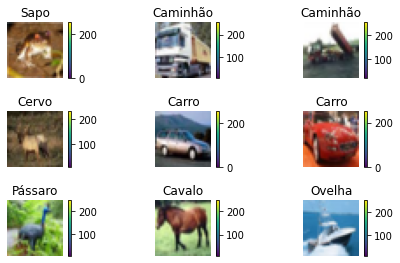

In [ ]:
for imagem in range(9):
  plt.subplot(3, 3, imagem+1)
  plt.tight_layout()
  plt.imshow(treino[0][imagem])
  plt.title(legendas[treino[1][imagem][0]])
  plt.axis("off")
  plt.colorbar()
plt.show()

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 4.3521 - accuracy: 0.0996
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3520 - accuracy: 0.1008
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3179 - accuracy: 0.0999
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3091 - accuracy: 0.0984
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3057 - accuracy: 0.1007
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3046 - accuracy: 0.0971
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3038 - accuracy: 0.0982
Epoch 8/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3035 - accuracy: 0.0990
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3033 - accuracy: 0.0995
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.303

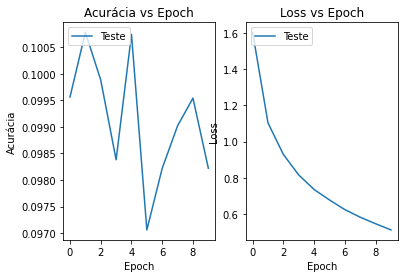

In [ ]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])

modelo.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer='adam')
historico_primeiro = modelo.fit(treino[0], treino[1], epochs=n_epochs, workers=n_workers)
plota_modelo(historico_primeiro)

Neste caso, o modelo produzido foi altamente insatisfatório, com uma acurácia pífia e extremamente variável com o número de epochs.

### Normalização dos Pixels
Como alternativa ao modelo anterior, utilizarmos imagens com o valor dos pixels normalizados, o que deve permitir um melhor processamento das imagens pela rede neural.

In [157]:
treino = list(treino)
teste = list(teste)

treino[0] = treino[0]/255.0
teste[0] = teste[0]/255.0

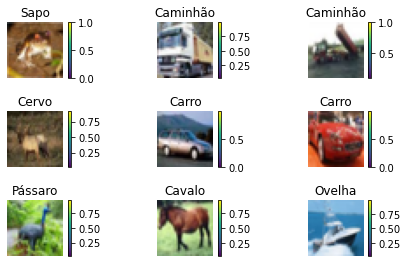

In [ ]:
for imagem in range(9):
  plt.subplot(3, 3, imagem+1)
  plt.tight_layout()
  plt.imshow(treino[0][imagem])
  plt.title(legendas[treino[1][imagem][0]])
  plt.axis("off")
  plt.colorbar()
plt.show()

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9183 - accuracy: 0.3093
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7224 - accuracy: 0.3848
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6450 - accuracy: 0.4119
Epoch 4/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5850 - accuracy: 0.4341
Epoch 5/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5481 - accuracy: 0.4476
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5123 - accuracy: 0.4609
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4768 - accuracy: 0.4743
Epoch 8/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.4439 - accuracy: 0.4853
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4243 - accuracy: 0.4912
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.393

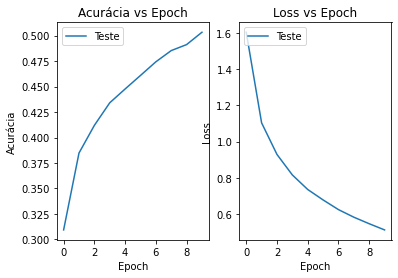

In [ ]:

modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])

modelo.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer='adam')
historico_normalizado = modelo.fit(treino[0], treino[1], epochs=n_epochs, workers=n_workers)
plota_modelo(historico_normalizado)

Apesar de ainda possuir uma acurácia baixa de apenas metade das imagens, o modelo possui uma clara melhora com relação ao anterior. A acurácia tende a crescer conforme aumenta-se o número de epochs. A velocidade de treinamento é também muito alta, com apenas 9 segundos para cada epoch, o que é um fator importante se considerarmos que estamos lidando com 50 000 imagens.

### Troca do Otimizador
O próximo passo na tentativa de melhorar o modelo será trocar o otimizador do modelo por um mais apropriado para trabalhar com este tipo de dado.

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.8119 - accuracy: 0.3584
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5724 - accuracy: 0.4449
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4918 - accuracy: 0.4732
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4481 - accuracy: 0.4889
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4105 - accuracy: 0.5019
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3859 - accuracy: 0.5107
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3634 - accuracy: 0.5203
Epoch 8/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3475 - accuracy: 0.5246
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3352 - accuracy: 0.5307
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.319

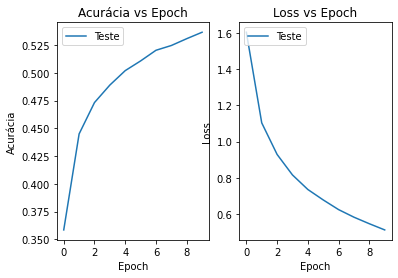

In [ ]:
# Trocando o otimizador
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])
modelo.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.001, decay = 1e-3, momentum = 0.3))
historico_otimizador = modelo.fit(treino[0], treino[1], epochs=n_epochs, workers=n_workers)
plota_modelo(historico_otimizador)

Houve um ganho de acurácia e uma pequena diminuição da perda, embora tenha sido em uma porcentagem muito pequena.

### Aumento das Camadas de Convolução
Procurando aumentar a complexidade da rede neural, utilizaremos mais camadas de convolução para buscar uma melhor avaliação das imagens.

Epoch 1/10
1563/1563 [==============================] - 45s 29ms/step - loss: 1.6218 - accuracy: 0.4156
Epoch 2/10
1563/1563 [==============================] - 44s 28ms/step - loss: 1.1835 - accuracy: 0.5756
Epoch 3/10
1563/1563 [==============================] - 45s 29ms/step - loss: 1.0256 - accuracy: 0.6335
Epoch 4/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.9357 - accuracy: 0.6673
Epoch 5/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.8741 - accuracy: 0.6875
Epoch 6/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.8238 - accuracy: 0.7079
Epoch 7/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.7872 - accuracy: 0.7203
Epoch 8/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.7561 - accuracy: 0.7313
Epoch 9/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.7256 - accuracy: 0.7413
Epoch 10/10
1563/1563 [==============================] - 46s 29m

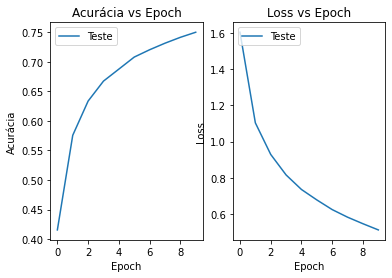

In [ ]:
# Adicionando várias camadas de convolução
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(32, 32, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])


modelo.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.RMSprop(lr=0.001, decay = 1e-3, momentum = 0.3))
historico_convolucao = modelo.fit(treino[0], treino[1], epochs=n_epochs, workers=n_workers)
plota_modelo(historico_convolucao)

Enfim foi possível obter um aumento bastante considerável da acurácia do modelo, o que nos leva a acreditar que as operações de convolução são o atributo de maior peso na avaliação das imagens pela rede neural.

### Incremento do Número de Neurônios
Pensando nisso, serão aumentados o número de neurônios dedicados a convolução em 4 vezes.

Epoch 1/10
1563/1563 [==============================] - 316s 202ms/step - loss: 1.7151 - accuracy: 0.3794
Epoch 2/10
1563/1563 [==============================] - 320s 204ms/step - loss: 1.2048 - accuracy: 0.5719
Epoch 3/10
1563/1563 [==============================] - 320s 204ms/step - loss: 1.0192 - accuracy: 0.6405
Epoch 4/10
1563/1563 [==============================] - 323s 207ms/step - loss: 0.9039 - accuracy: 0.6805
Epoch 5/10
1563/1563 [==============================] - 323s 207ms/step - loss: 0.8168 - accuracy: 0.7110
Epoch 6/10
1563/1563 [==============================] - 323s 207ms/step - loss: 0.7470 - accuracy: 0.7362
Epoch 7/10
1563/1563 [==============================] - 317s 203ms/step - loss: 0.6894 - accuracy: 0.7556
Epoch 8/10
1563/1563 [==============================] - 312s 200ms/step - loss: 0.6349 - accuracy: 0.7744
Epoch 9/10
1563/1563 [==============================] - 313s 200ms/step - loss: 0.5921 - accuracy: 0.7904
Epoch 10/10
1563/1563 [=======================

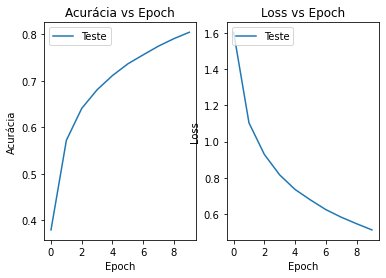

In [ ]:
# Adicionando vários camadas de convolução
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), input_shape=(32, 32, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])


modelo.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.RMSprop(lr=0.001, decay = 1e-3, momentum = 0.3))
historico_aumento = modelo.fit(treino[0], treino[1], epochs=n_epochs, workers=n_workers)
plota_modelo(historico_aumento)

Foi possível conseguir um aumento de 5% na acurácia, contudo, o tempo de processamento tornou-se cerca de 7.5 vezes maior do que o anterior.

### Adição de MaxPooling e Normalização da Amostra
Como última tentativa de melhorar o modelo, serão adicionadas duas camadas, uma de MaxPooling para evitar que o modelo receba as imagens sempre da mesma meneira e uma de normalização para estabilizar o processo de treinamento e diminuir o número de epochs necessárias para aperfeiçoar a rede neural.

Epoch 1/10
1563/1563 [==============================] - 92s 59ms/step - loss: 1.5747 - accuracy: 0.4469
Epoch 2/10
1563/1563 [==============================] - 91s 58ms/step - loss: 1.0855 - accuracy: 0.6210
Epoch 3/10
1563/1563 [==============================] - 94s 60ms/step - loss: 0.9043 - accuracy: 0.6839
Epoch 4/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.7905 - accuracy: 0.7239
Epoch 5/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.7112 - accuracy: 0.7506
Epoch 6/10
1563/1563 [==============================] - 90s 58ms/step - loss: 0.6503 - accuracy: 0.7711
Epoch 7/10
1563/1563 [==============================] - 90s 58ms/step - loss: 0.5973 - accuracy: 0.7899
Epoch 8/10
1563/1563 [==============================] - 90s 58ms/step - loss: 0.5551 - accuracy: 0.8038
Epoch 9/10
1563/1563 [==============================] - 90s 58ms/step - loss: 0.5130 - accuracy: 0.8182
Epoch 10/10
1563/1563 [==============================] - 90s 58m

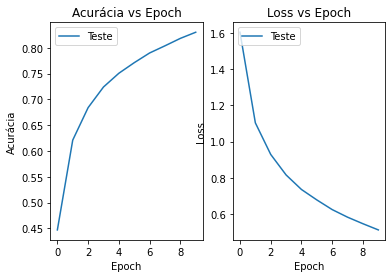

In [ ]:
# Adicionando vários camadas de convolução
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), input_shape=(32, 32, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])


modelo.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.RMSprop(lr=0.001, decay = 1e-3, momentum = 0.3))
historico_norm = modelo.fit(treino[0], treino[1], epochs=n_epochs, workers=n_workers)
plota_modelo(historico_norm)

Houve um pequeno aumento na acurácia do modelo, contudo o aumento na velocidade de treinamento foi notável.

### Treinamento Final
Com este último modelo, realizaremos o treinamento utilizando agora 100 epochs, com o objetivo de atingir uma maior precisão. Também utilizaremos 5 vezes mais workers na tentativa de agilizar o treinamento.

Epoch 1/100
1563/1563 [==============================] - 79s 50ms/step - loss: 1.5301 - accuracy: 0.4619
Epoch 2/100
1563/1563 [==============================] - 75s 48ms/step - loss: 1.0781 - accuracy: 0.6231
Epoch 3/100
1563/1563 [==============================] - 78s 50ms/step - loss: 0.9125 - accuracy: 0.6793
Epoch 4/100
1563/1563 [==============================] - 79s 51ms/step - loss: 0.7985 - accuracy: 0.7181
Epoch 5/100
1563/1563 [==============================] - 80s 51ms/step - loss: 0.7215 - accuracy: 0.7440
Epoch 6/100
1563/1563 [==============================] - 83s 53ms/step - loss: 0.6596 - accuracy: 0.7662
Epoch 7/100
1563/1563 [==============================] - 82s 53ms/step - loss: 0.6067 - accuracy: 0.7848
Epoch 8/100
1563/1563 [==============================] - 82s 52ms/step - loss: 0.5659 - accuracy: 0.7989
Epoch 9/100
1563/1563 [==============================] - 82s 52ms/step - loss: 0.5293 - accuracy: 0.8118
Epoch 10/100
1563/1563 [==============================]

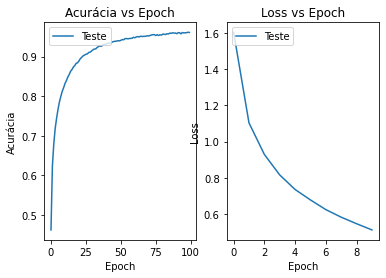

In [158]:
# Adicionando vários camadas de convolução
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), input_shape=(32, 32, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])


modelo.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.RMSprop(lr=0.001, decay = 1e-3, momentum = 0.3))
historico_max_norm = modelo.fit(treino[0], treino[1], epochs=10*n_epochs, workers=5*n_workers)
plota_modelo(historico_max_norm)

## Validação e Testes
O modelo agora possui uma alta acurácia, obtida ao custo de um processamento intenso de mais de 2 horas e meia.

Agora será possível validar o modelo utilizando o conjunto de imagens de teste disponibilidados pelo próprio tensorflow, bem como tentar realizar a predicção das categorias das imagens.

In [163]:
modelo_json = modelo.to_json()
with open("modelo.json", "w") as arquivo_modelo:
   arquivo_modelo.write(modelo_json)

perda_validacao, acuracia_validacao = modelo.evaluate(teste[0], teste[1])
print("A acurácia da validação foi de: {}, com uma perda de {}.".format(acuracia_validacao, perda_validacao))


313/313 [==============================] - 4s 12ms/step - loss: 1.4880 - accuracy: 0.7111
A acurácia da validação foi de: 0.7110999822616577, com uma perda de 1.4879887104034424.


In [167]:
predicao = modelo.predict(teste[0])

In [191]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(legendas[predicted_label],
                                100*np.max(predictions_array),
                                legendas[int(true_label)]),
                                color=color)

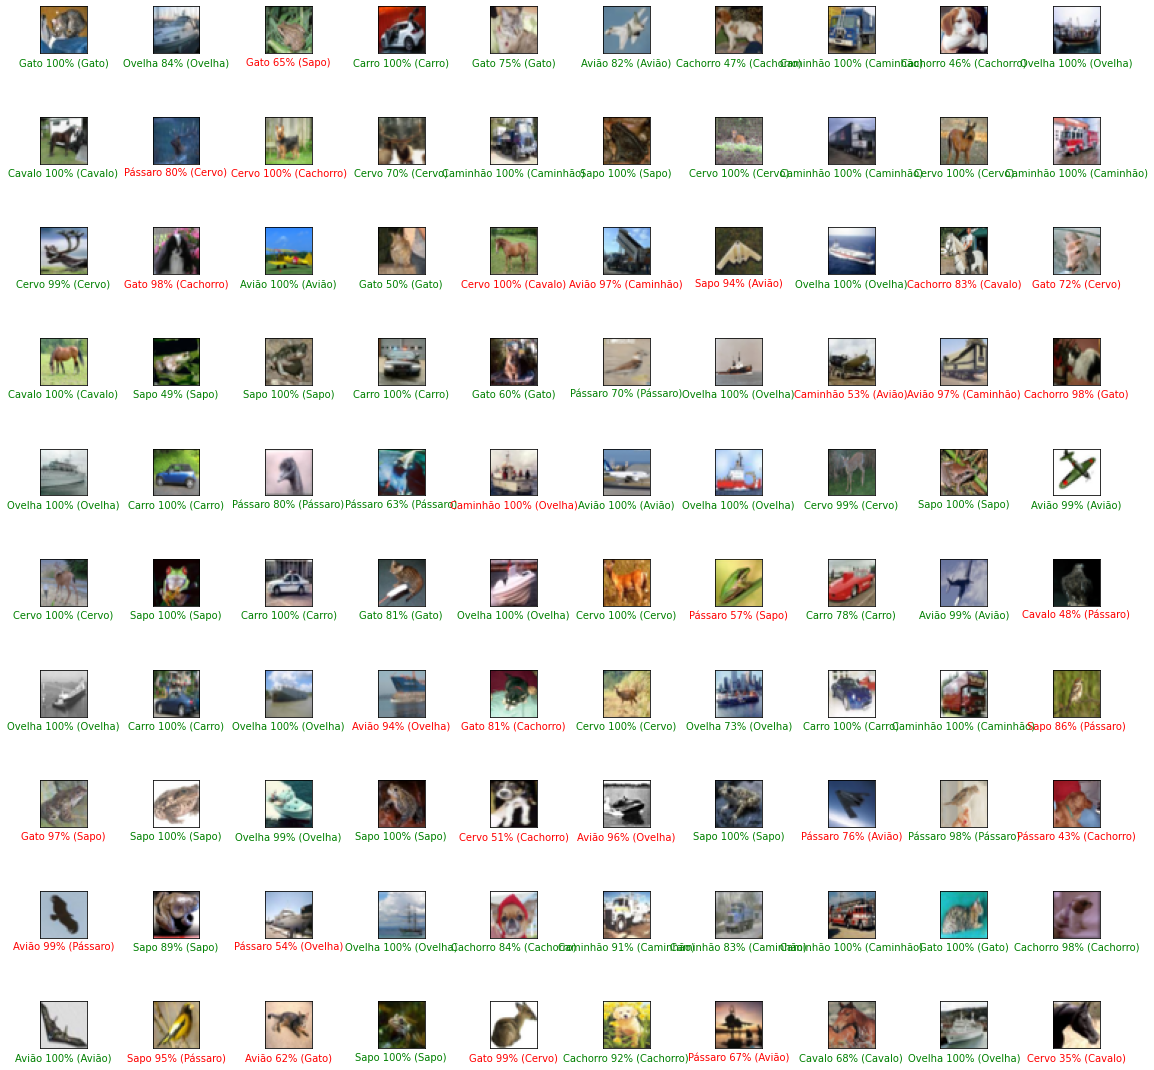

In [192]:
num_rows = 10
num_cols = 10
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(2*i, predicao, teste[1], teste[0])
plt.show()

## Resultado
Apesar do modelo apresentar uma boa acurácia no treinamento, os resultados obtidos nos testes não foi tão satisfatória, apresentando apenas 71% de acertos. O que, comparado ao 96% do modelo original estão muito distantes do esperado.

Acima, são mostradas algumas imagens utilizadas nos testes, as quais são legendadas em verde, quando foram previstas corretamente, e vermelhas caso contrário. É especificado a categoria prevista para a imagem e o nível de confiança do modelo em sua predição. Entre parênteses está indicada a verdadeira classe a que pertence a imagem.

Talvez a modelagem dos dados tenha levado a um overfitting do modelo para as imagens de treinamento, tornando-o incapaz de descrever com precisão outros cenários.

## Referências
Para construir o modelo foram pesquisados diversos notebooks no Kaggle sobre
tratamento de imagens, a documentação do Keras, bem como diversos artigos do site www.machinelearningmastery.com.

Os principais artigos utilizados foram:

https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
